In [1]:
# import required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor   
from sklearn.grid_search import GridSearchCV 
from xgboost import XGBRegressor
import yaml


C:\Users\nitin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nitin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Data Preparation

In [2]:
# Reading the file
with open("./gbm_param.yml", 'r') as f:
    params = yaml.safe_load(f)
input_data_path = params['input_data_path']
df1 = pd.read_csv(input_data_path)
df1.head(3)

year  month  High000075.KS  Low000075.KS  Open000075.KS  Close000075.KS  \
0  2007.0    1.0    29095.03065   28337.10757    28634.98438     29012.06926   
1  2007.0    2.0    27798.58185   27415.33612    27696.08185     27669.34553   
2  2007.0    3.0    26590.06885   26035.55029    26406.25635     26344.97522   

   High000157.KS  Low000157.KS  Open000157.KS  Close000157.KS     ...       \
0    22272.72727   21654.54545    22004.54545     22004.54545     ...        
1    21921.05263   21218.42105    21547.36842     21584.21053     ...        
2    27935.00000   26882.50000    27230.00000     27770.00000     ...        

   OpenWHE.BE  CloseWHE.BE  HighWHRL3.SA  LowWHRL3.SA  OpenWHRL3.SA  \
0       0.436        0.436      2.339524     2.171429      2.171429   
1       0.436        0.436      2.342222     2.125000      2.176667   
2       0.436        0.436      2.381364     2.211818      2.256364   

   CloseWHRL3.SA    High^IXIC     Low^IXIC    Open^IXIC   Close^IXIC  
0       2.188571  2465.036011  2436.571997  2451.197498  2453.187000  
1       2.176111  2491.339458  2466.998420  2482.686845  2479.864194  
2       2.300909  2414.307273  2386.536366  2401.696811  2401.490867  

[3 rows x 3046 columns]

In [3]:
df1.shape

(134, 3046)

In [4]:
 df1 = df1.drop(['year','month'],axis=1)

In [5]:
# defining Independent and Dependent Variables
x = df1.drop(['Close^IXIC'],axis=1)
y = df1['Close^IXIC']

### Transformation Followed by VIF based removal

In [6]:
### Transformation 2

def Transformations(df):
    
    """
    Function to generate Transformed features and to check for appropriate transformations, 
    Transformed variable with a better R-square is appended to the original dataset.
    
    # Arguments
        df: Input dataframe
        
    # Returns
        dataframe: Return a dataframe with Transformed Variables
    """
    
    
    #from scipy.stats import shapiro
    lr = LinearRegression()
    transf=['never',"_sq","_sqroot",'_inv','_log']
    for col in df.columns:


        ### Transformations

        #exp = np.where( (df[col]!=0),np.exp(df[col]),0)
        sq_root = np.sqrt(df[col])
        sq = np.square(df[col])

        inv = np.where( (df[col]!=0), np.reciprocal(df[col]), 0)
        log = np.where( (df[col]!=0),np.log(df[col]),0)
        l=[df[col],sq,sq_root,inv,log]

        r2_list = []  # To store r-square for each variable present in the list
        for var in l:

            lr.fit(np.array(var).reshape(-1,1),y)
            r2_list.append(lr.score(np.array(var).reshape(-1,1),y))

        ind = np.argmax(r2_list) 
        #print(ind)

        if ind !=0:

            df=df.drop([col],axis=1)
            df[col+transf[ind]] = l[ind]
            df_new=df

    return (df_new)

In [7]:
import time 
#%%time
start=time.time()
df_new = Transformations(x)
end=time.time()
t1= end-start

In [8]:
df_new.head()

High000157.KS  Open000157.KS  Close000157.KS  High001340.KS  Low001340.KS  \
0    22272.72727    22004.54545     22004.54545    1419.876814   1383.255005   
1    21921.05263    21547.36842     21584.21053    1369.546303   1333.107865   
2    27935.00000    27230.00000     27770.00000    1340.079498   1314.479004   
3    36790.47619    36276.19048     36509.52381    1417.914754   1378.439035   
4    47566.66667    46473.80952     47185.71429    1882.849046   1755.836664   

   Open001340.KS  Close001340.KS  Low002710.KS  Open002710.KS  High0064.HK  \
0    1405.940446     1391.985457   2494.111839    2537.644076     0.626888   
1    1356.713128     1355.935245   2574.166838    2602.787906     0.688473   
2    1323.529999     1326.780994   2643.530518    2678.228503     0.685323   
3    1395.679036     1408.766648   2862.187163    2913.767613     0.683222   
4    1818.463332     1838.517613   3297.652390    3336.271880     0.737314   

         ...          OpenW1D.BE_log  CloseW1D.BE_log  HighW1D.F_sqroot  \
0        ...                3.225936         3.227390          2.791632   
1        ...                3.339030         3.331858          2.791632   
2        ...                3.238945         3.239902          2.791632   
3        ...                3.291242         3.294394          2.791632   
4        ...                3.593568         3.595882          2.791632   

   LowW1D.F_sqroot  OpenW1D.F_sqroot  CloseW1D.F_sqroot  HighWHRL3.SA_inv  \
0         2.791632          2.791632           2.791632          0.427437   
1         2.791632          2.791632           2.791632          0.426945   
2         2.791632          2.791632           2.791632          0.419927   
3         2.791632          2.791632           2.791632          0.398565   
4         2.791632          2.791632           2.791632          0.201742   

   LowWHRL3.SA_log  OpenWHRL3.SA_inv  CloseWHRL3.SA_log  
0         0.775385          0.460526           0.783249  
1         0.753772          0.459418           0.777539  
2         0.793815          0.443191           0.833304  
3         0.888920          0.406339           0.904623  
4         1.482327          0.213364           1.537747  

[5 rows x 3043 columns]

In [9]:
## VIF based removal
def Vif_Rem(df,r_square_threshold):
    
    """
    Function to  remove variables iteratively that are multicollinear with other variables in the dataset.
    
    # Arguments
        df: Input dataframe
        r_square_threshold: R-Square-Threshold to remove variables. 
                            0.9 r-square corresponds to a VIF of 10 , 0.8 r-square corresponds to a VIF of 5
        
    # Returns
        dataframe: Return a dataframe with non collinear variables.
    """
    
    lr = LinearRegression()
    for col in df.columns:
        lr.fit(df.drop([col],axis=1),df[col])
        if lr.score(df.drop([col],axis=1),df[col]) >= r_square_threshold:  # R-square - 0.9 corresponds to a VIF of 10
            df=df.drop([col],axis=1)
    return(df)  
    
    

In [10]:
start=time.time()
# R-square of .9 ~ VIF of 10
df_new=Vif_Rem(df_new,0.9)
end=time.time()
v1=end-start


In [11]:
### Total time to run the code

tot_time = t1+v1

print("Total time for Transformation followed by VIF removal: ",tot_time )

Total time for Transformation followed by VIF removal:  174.83685541152954


In [12]:
len(df_new.columns)

8

In [13]:
df_new.columns

Index(['CloseULC.SG_sq', 'CloseUNICHEMLAB.BO_inv', 'CloseUNJ.F_inv',
       'CloseUTSI.MX_inv', 'CloseVIVIMEDLAB.NS_sq', 'CloseVJLAXMIE.BO_inv',
       'CloseW1D.F_sqroot', 'CloseWHRL3.SA_log'],
      dtype='object')

### GBM - With Hyperparameter Tuning using GridSearch

In [14]:
# define gridSearch GBM with includes default Parameters
def gbm(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,x,y):
    
    default_params = {'max_depth' : 3, 'min_samples_split':2, 'n_estimators':100, 'learning_rate':0.1}
    if [default_params['max_depth']] not in max_depth_l:
        max_depth_l.append(default_params['max_depth'])
        
    if [default_params['min_samples_split']] not in min_samples_split_l:    
        min_samples_split_l.append(default_params['min_samples_split'])
        
    if [default_params['n_estimators']] not in n_estimators_l:     
        n_estimators_l.append(default_params['n_estimators'])
        
    if [default_params['learning_rate']] not in learning_rate_l: 
        learning_rate_l.append(default_params['learning_rate'])
    
    
    
    """
    Function to generate Variable Importance Plot on the basis of GBM.
    
    # Arguments
        x: Input dataframe - Independent features
        y: Input dataframe - Target feature
        max_depth_l: list of max_depth hyperparameter
        min_samples_split_l: list of min_samples_split hyperparameter
        n_estimators_l: list of n_estimators_l hyperparameter
        learning_rate_l: list of learning_rate_l hyperparameter
        
    # Returns
        dataframe: Return a dataframe with Transformed Variables
    """
    
    
    param_test = {'max_depth':max_depth_l, 'min_samples_split':min_samples_split_l,
                   'n_estimators': n_estimators_l, 'learning_rate': learning_rate_l}
    gsearch = GridSearchCV(estimator = GradientBoostingRegressor(max_features='sqrt', subsample=0.8, random_state=10), 
    param_grid = param_test, scoring='r2',n_jobs=4,iid=False, cv=5)
    gsearch.fit(x,y)
    #gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

    gbm = GradientBoostingRegressor(learning_rate = gsearch.best_params_['learning_rate'] , min_samples_split =gsearch.best_params_['min_samples_split'],
                                   n_estimators = gsearch.best_params_['n_estimators'], max_depth = gsearch.best_params_['max_depth'])
    gbm.fit(x,y)
    features_df = pd.DataFrame({'feature': x.columns,'gbm_feature_importances_':gbm.feature_importances_,}).sort_values('gbm_feature_importances_',ascending=False).reset_index()

    return(sns.barplot(x='gbm_feature_importances_',y='feature',data=features_df))
    

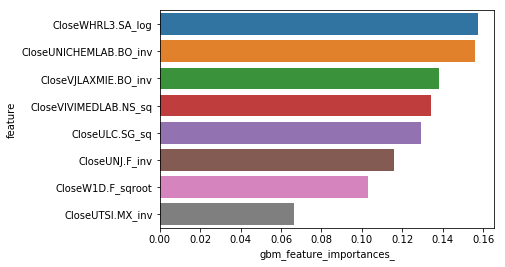

In [15]:
start = time.time()
# paramaters from the gbm_param.yml file
max_depth_l = params['max_depth_l']
min_samples_split_l = params['min_samples_split_l']
n_estimators_l = params['n_estimators_l']
learning_rate_l = params['learning_rate_l']

# Claaing GBM function
gbm(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,df_new,y)
end= time.time()


In [16]:
tot_time = end-start
print("Time taken to run GBM with Hyperparameter tuning: ",tot_time)

Time taken to run GBM with Hyperparameter tuning:  33.53154754638672


### XGBoost

In [17]:
#  XGBoost with GridSearch
def xgb_grid(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,x,y):
    
    default_params = {'max_depth' : 3, 'min_samples_split':2, 'n_estimators':100, 'learning_rate':0.1}
    if [default_params['max_depth']] not in max_depth_l:
        max_depth_l.append(default_params['max_depth'])
        
    if [default_params['min_samples_split']] not in min_samples_split_l:    
        min_samples_split_l.append(default_params['min_samples_split'])
        
    if [default_params['n_estimators']] not in n_estimators_l:     
        n_estimators_l.append(default_params['n_estimators'])
        
    if [default_params['learning_rate']] not in learning_rate_l: 
        learning_rate_l.append(default_params['learning_rate'])
    
    
    
    """
    Function to generate Variable Importance Plot on the basis of GBM.
    
    # Arguments
        x: Input dataframe - Independent features
        y: Input dataframe - Target feature
        max_depth_l: list of max_depth hyperparameter
        min_samples_split_l: list of min_samples_split hyperparameter
        n_estimators_l: list of n_estimators_l hyperparameter
        learning_rate_l: list of learning_rate_l hyperparameter
        
    # Returns
        dataframe: Return a dataframe with Transformed Variables
    """
    
    
    param_test = {'max_depth':max_depth_l, 'min_samples_split':min_samples_split_l,
                   'n_estimators': n_estimators_l, 'learning_rate': learning_rate_l}
    gsearch = GridSearchCV(estimator = XGBRegressor(max_features='sqrt', subsample=0.8, random_state=10), 
    param_grid = param_test, scoring='r2',n_jobs=4,iid=False, cv=5)
    gsearch.fit(x,y)
    #gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

    xgb1 = XGBRegressor(learning_rate = gsearch.best_params_['learning_rate'] , min_samples_split =gsearch.best_params_['min_samples_split'],
                                   n_estimators = gsearch.best_params_['n_estimators'], max_depth = gsearch.best_params_['max_depth'])
    xgb1.fit(x,y)
    features_df = pd.DataFrame({'feature': x.columns,'xgb_feature_importances_':xgb1.feature_importances_,}).sort_values('xgb_feature_importances_',ascending=False).reset_index()

    return(sns.barplot(x='xgb_feature_importances_',y='feature',data=features_df))
    

In [18]:
params

{'input_data_path': './Finance_Final_data_sanity_check.csv',
 'max_depth_l': [3, 5, 7, 3],
 'min_samples_split_l': [5, 10, 2],
 'n_estimators_l': [50, 300, 500, 100],
 'learning_rate_l': [0.15, 0.2, 0.1]}

[19:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


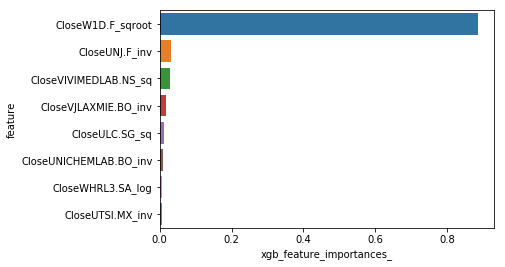

In [19]:
start = time.time()
# Calling the yaml file
with open("./xgb_param.yml", 'r') as f:
    params = yaml.safe_load(f)
max_depth_l = params['max_depth_l']
min_samples_split_l = params['min_samples_split_l']
n_estimators_l = params['n_estimators_l']
learning_rate_l = params['learning_rate_l']

xgb_grid(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,df_new,y)
end= time.time()

In [20]:
tot_time = end-start
print("Time taken to run GBM with Hyperparameter tuning: ",tot_time)

Time taken to run GBM with Hyperparameter tuning:  35.7774395942688
